<a href="https://colab.research.google.com/github/Samplerbhavanigithub/FMML-2023_PROJECTS_AND_ASSIGNMENTS/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-10 14:35:54--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.225.4.25, 13.225.4.72, 13.225.4.109, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.225.4.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   122MB/s    in 0.4s    

2024-05-10 14:35:55 (122 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


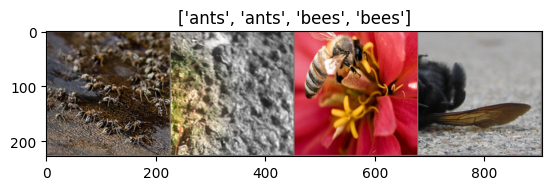

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5600 Acc: 0.7090

Epoch 1/4
----------
Loss: 0.5515 Acc: 0.7664

Epoch 2/4
----------
Loss: 0.4383 Acc: 0.8402

Epoch 3/4
----------
Loss: 0.4845 Acc: 0.7869

Epoch 4/4
----------
Loss: 0.4156 Acc: 0.8238



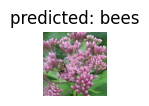

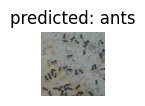

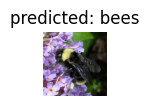

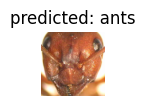

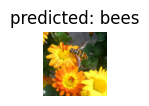

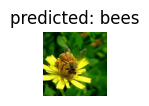

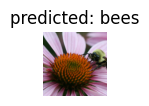

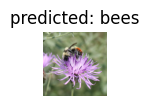

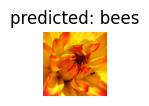

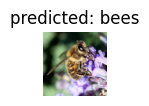

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


**Question 1**


Data augmentations like resize, crop, flip, rotation, and color jittering play a crucial role in training Convolutional Neural Networks (CNNs) for several reasons:

Increased Robustness: Augmenting data introduces variability into the training set, making the model more robust to variations it might encounter during inference. For instance, resizing and cropping help the model learn to recognize objects at different scales and viewpoints.
Improved Generalization: By presenting the model with diverse versions of the same data, augmentations help prevent overfitting. The model learns to focus on the invariant features of the data while disregarding irrelevant details.
Expanding Training Data: With a limited dataset, augmentations effectively increase the effective size of the training set. This is particularly important when working with small datasets, where overfitting is a significant concern.
Regularization: Augmentations act as a form of regularization by adding noise to the training process. This can help prevent the model from memorizing the training data and encourage it to learn more generalizable patterns.
Adaptation to Real-World Scenarios: Data augmentations can simulate real-world scenarios such as occlusions, distortions, and variations in lighting conditions, thus making the model more adaptable to unseen data during deployment.
Overall, data augmentations contribute to the robustness, generalization, and performance of CNNs by enriching the training dataset and promoting better learning of invariant features

**Question 2**

If you don't use a pre-trained ResNet model and instead train the model from scratch (by setting pretrained=False), the performance might not be as good as when using pre-trained weights. Training a deep neural network from scratch requires a large amount of labeled data and computational resources, as well as careful hyperparameter tuning and regularization techniques to prevent overfitting.

Without pre-training, the network initializes its weights randomly, which means it starts with no prior knowledge about the task. Consequently, it might take longer to converge to a good solution, and there's a risk of getting stuck in suboptimal local minima.

The performance you achieve without pre-trained weights depends on various factors such as the complexity of your dataset, the architecture of the network, the amount of training data, the quality of the data, the optimizer used, and the training hyperparameters. In general, the performance might be lower compared to using pre-trained weights, especially if you have a limited amount of training data.

To accurately assess the performance, you would need to train the model on your specific dataset and evaluate its performance using appropriate metrics such as accuracy, precision, recall, or F1-score, depending on the task.






In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Define ResNet18 model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 10)  # CIFAR-10 has 10 classes
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')


100%|██████████| 170498071/170498071 [00:12<00:00, 13148945.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[1,   100] loss: 2.087
[1,   200] loss: 1.829
[1,   300] loss: 1.729
[1,   400] loss: 1.637
[1,   500] loss: 1.594
[1,   600] loss: 1.537
[1,   700] loss: 1.507
[2,   100] loss: 1.424
[2,   200] loss: 1.389
[2,   300] loss: 1.368
[2,   400] loss: 1.331
[2,   500] loss: 1.322
[2,   600] loss: 1.276
[2,   700] loss: 1.268
[3,   100] loss: 1.218
[3,   200] loss: 1.196
[3,   300] loss: 1.193
[3,   400] loss: 1.194
[3,   500] loss: 1.142
[3,   600] loss: 1.124
[3,   700] loss: 1.108
[4,   100] loss: 1.061
[4,   200] loss: 1.082
[4,   300] loss: 1.041
[4,   400] loss: 1.038
[4,   500] loss: 1.042
[4,   600] loss: 1.012
[4,   700] loss: 1.009
[5,   100] loss: 0.999
[5,   200] loss: 0.963
[5,   300] loss: 0.948
[5,   400] loss: 0.928
[5,   500] loss: 0.956
[5,   600] loss: 0.907
[5,   700] loss: 0.918
[6,   100] loss: 0.893
[6,   200] loss: 0.880
[6,   300] loss: 0.868
[6,   400] loss: 0.877
[6,   500] loss: 0.848
[6,   600] loss: 0.846
[6,   700] loss: 0.842
[7,   100] loss: 0.816
[7,   200] 

**Question 3**

The performance of a pre-trained ResNet model on the ants vs. bees dataset would depend on the similarity between the dataset it was originally trained on and the ants vs. bees dataset. If the original dataset and the ants vs. bees dataset share similar visual characteristics (e.g., both contain natural images), then using the pre-trained ResNet model as a starting point for transfer learning could lead to good performance. The pre-trained model would have learned general features that are likely to be applicable to various image recognition tasks.

However, if the original dataset was significantly different from the ants vs. bees dataset (e.g., medical images or satellite images), the performance might not be as good initially. In such cases, fine-tuning the pre-trained model on the ants vs. bees dataset or using other transfer learning techniques could help adapt the model's features to the new task, potentially improving performance.